In [ ]:
!pip install tensorflow
!pip install keras
!pip install librosa

In [3]:
import os
import pickle
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

#Autoencoder
class Autoencoder:
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2

        self.encoder = None
        self.decoder = None
        self.model = None



        #Private attributes

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input=None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        #This is autoEncoder model
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        #In keras we need to compile before using model
        optimizer = Adam(learning_rate=learning_rate)
        #We are using Mean Squared error loss
        mse_loss = MeanSquaredError()
        #self model is our autoencoder model
        self.model.compile(optimizer=optimizer, loss=mse_loss)


    def train(self, x_train, batch_size, num_epochs):
        # we expect same output as input
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)





    def save(self, save_folder="."):
        #save the main directory folder
        #Create a save folder if it doesnt exist
        self._create_folder_if_it_doesnt_exist(save_folder)
        #Save the parameters in the save folder
        self._save_parameters(save_folder)
        #Save the weights in the save folder
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        #Then load the model with weights
        self.model.load_weights(weights_path)


    def reconstruct(self, images):
        #in the lantent space respresentation we will predict image from encoder
        latent_representations = self.encoder.predict(images)
        #Decoder will reconstruct the image from lantent respresentation
        reconstructed_images = self.decoder.predict(latent_representations)
        #Then this function will return Reconstructed image and its latent representation
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = Autoencoder(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        #We want to save parameters as input
        #They are organized in List
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        #Save all the parameters in file name parameters.pkl
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)
    #Save all the weights
    def _save_weights(self, save_folder):
        #Save the weights in weights.h5
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)


    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()


    def _build_autoencoder(self):
      model_input = self._model_input
      model_output = self.decoder(self.encoder(model_input))
      self.model = Model(model_input, model_output, name="autoencoder")



    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input=encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck (Dense layer)."""
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        return x




In [7]:
#Train
from tensorflow.keras.datasets import mnist



LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20


def load_mnist():
    #we are Loading Mnist Dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #We are converting x train to float and normalizing them
    x_train = x_train.astype("float32") / 255
    #We are adding an extra dimension
    x_train = x_train.reshape(x_train.shape + (1,))
    #We are converting x test to float and normalizing them
    x_test = x_test.astype("float32") / 255
    #We are adding an extra dimension
    x_test = x_test.reshape(x_test.shape + (1,))

    return x_train, y_train, x_test, y_test


def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = Autoencoder(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder


if __name__ == "__main__":
    x_train, _, _, _ = load_mnist()
    #Here we just want to use train x thats why we dashed all the others
    autoencoder = train(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
    #We are saving the model
    autoencoder.save("model")
    #Then in autoencoder we load model
    autoencoder2 = Autoencoder.load("model")
    #Then we get the summary of the autoencoder 2
    autoencoder2.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv  (None, 28, 28, 32)        320       
 2D)                                                             
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormali  (None, 28, 28, 32)        128       
 zation)                                                         
                                                                 
 encoder_conv_layer_2 (Conv  (None, 14, 14, 64)        18496     
 2D)                                                             
                                                           

1/1 [==============================] - 0s 207ms/step


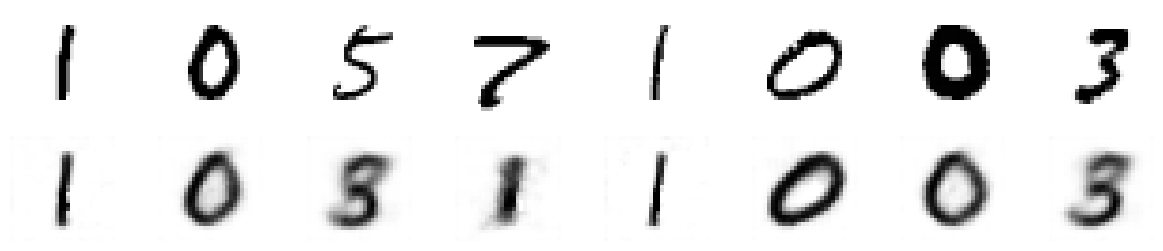

188/188 [==============================] - 6s 31ms/step


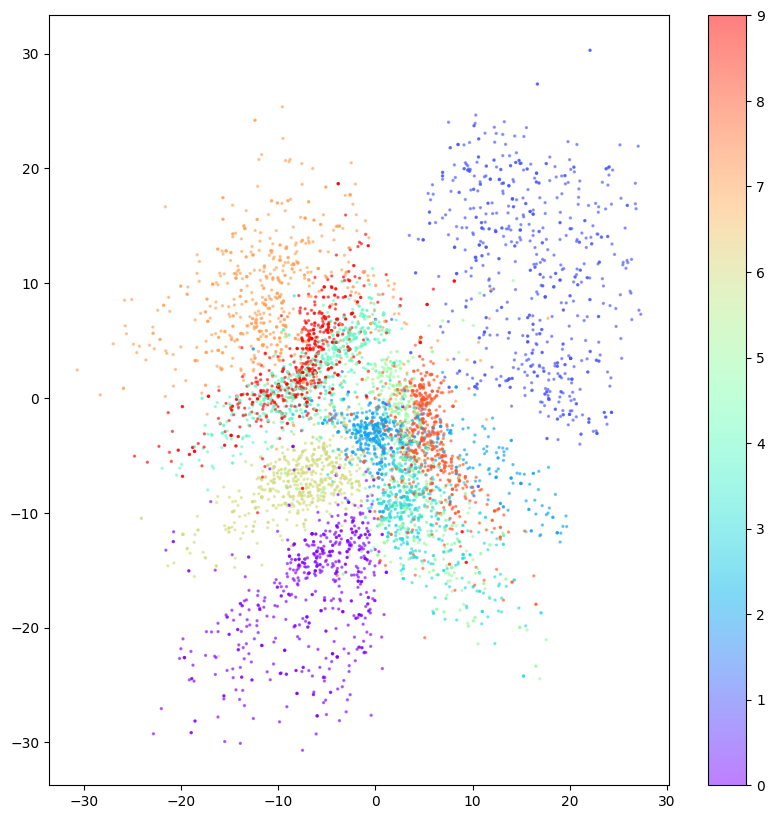

In [8]:
#Analysis


import numpy as np
import matplotlib.pyplot as plt



def select_images(images, labels, num_images=10):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels


def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()


def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()


if __name__ == "__main__":
    #loading the autoencoder model
    autoencoder = Autoencoder.load("model")
    x_train, y_train, x_test, y_test = load_mnist()
    #Comparing original images with reconstructed images
    num_sample_images_to_show = 8
    #we took the sample images and ignored the labels
    sample_images, _ = select_images(x_test, y_test, num_sample_images_to_show)
    #Giving the images to autoencoder to construct them back
    reconstructed_images, _ = autoencoder.reconstruct(sample_images)
    plot_reconstructed_images(sample_images, reconstructed_images)

    num_images = 6000
    sample_images, sample_labels = select_images(x_test, y_test, num_images)
    _, latent_representations = autoencoder.reconstruct(sample_images)
    plot_images_encoded_in_latent_space(latent_representations, sample_labels)

In [5]:

if __name__ == "__main__":
    autoencoder = Autoencoder(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv  (None, 28, 28, 32)        320       
 2D)                                                             
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormali  (None, 28, 28, 32)        128       
 zation)                                                         
                                                                 
 encoder_conv_layer_2 (Conv  (None, 14, 14, 64)        18496     
 2D)                                                             
                                                           